# Counting sorghum grains through deep crowd density methods

## Generating equal rectangles from images

### Libraries

In [30]:
import cv2
import os

### Cropping images

In [36]:
# Path to your input folder containing images
input_folder = "./../Data/counted_sorghum_panicles/test/"
# Path to the output folder for cropped images
output_folder = "./original_size"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate over image files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".png"):  # Assuming your images are in PNG format
        image_path = os.path.join(input_folder, filename)

        # Load the image
        image = cv2.imread(image_path)

        # Calculate the height of each cropped region
        height, width = image.shape[:2]
        crop_height = height // 3

        # Crop and save the images
        for i in range(3):
            # Calculate the coordinates for cropping
            y1 = i * crop_height
            y2 = (i + 1) * crop_height

            # Crop the region
            cropped_image = image[y1:y2, :]
            #cropped_image = cv2.resize(cropped_image, [224,224])

            # Define the output file name for each cropped image
            output_filename = os.path.join(output_folder, f"{i}_{filename}")

            # Save the cropped image
            cv2.imwrite(output_filename, cropped_image)

print("Images cropped and saved.")

Images cropped and saved.


## Cropping images labeled

### Importing Libraries

In [1]:
import numpy as np
import cv2 
import os
from collections import defaultdict
import json
import matplotlib.pyplot as plt

### Functions

In [2]:
def extract_points(filePath):
    
    f = open(filePath, 'r')

    data = json.load(f)

    points = data['shapes'][0]['points']

    f.close

    return(points)

def crop_image(imagePath, coordinates):
    
    img = cv2.imread(imagePath, 1)
    mask = np.zeros(img.shape[0:2], dtype=np.uint8)
    points = np.array([coordinates])
    pontos = points.astype(int)
    cv2.fillPoly(mask, pontos, (255))
    res = cv2.bitwise_and(img,img,mask = mask)
    return(res)

def remove_background(image):

    tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(image)
    rgba = [b, g, r, alpha]
    dst = cv2.merge(rgba, 4)
    return(dst)

### Cropping images, displaying and saving in separate folder

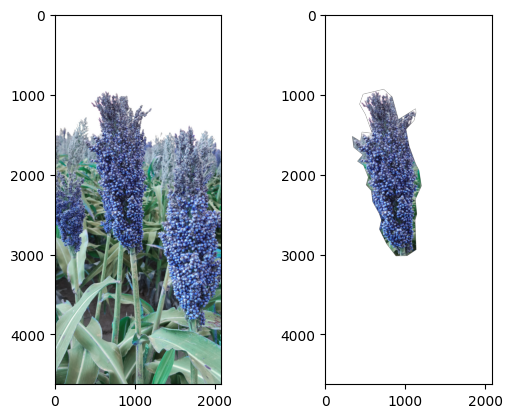

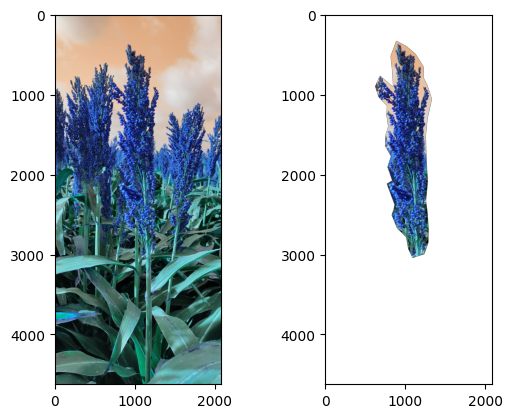

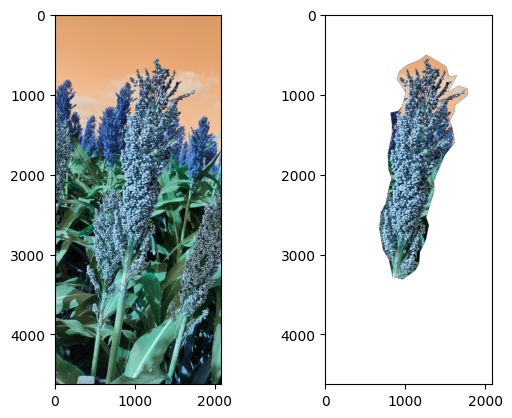

In [4]:
folder = './../Data/counted_sorghum_panicles/test'

EXTENSIONS = {'.json', '.jpg'}

grouped_files = defaultdict(int)

for f in os.listdir(folder):
    name, ext = os.path.splitext(os.path.join(folder, f))
    if ext in EXTENSIONS:
        grouped_files[name] += 1

for name in grouped_files:
    if grouped_files[name] == len(EXTENSIONS):
        with open('{}.jpg'.format(name)) as jpg_file, open('{}.json'.format(name)) as json_file:
            filePath = json_file.name
            imagePath = jpg_file.name

            coordinates = extract_points(filePath= filePath)
            imageCroped = crop_image(imagePath= imagePath, coordinates= coordinates)
            removed = remove_background(image = imageCroped)

            cropedImageName = os.path.splitext(imagePath)[0]+'.png'
            old_image = cv2.imread(imagePath)
            cv2.imwrite(cropedImageName, removed)
            # Display the output image
            fig = plt.figure()
            ax1 = fig.add_subplot(1,2,1)
            ax1.imshow(old_image)
            ax2 = fig.add_subplot(1,2,2)
            ax2.imshow(removed)

## Data augmentation

### Libraries

In [14]:
import cv2
import json
import os
import numpy as np
from imgaug import augmenters as iaa
import copy

### Augmenting images

In [17]:
# Define the input and output directories
input_image_dir = "./../Data/images_rectangle"
output_image_dir = "./images"
input_json_dir = "./../Data/images_rectangle"
output_json_dir = "./labels"

# Create output directories if they don't exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_json_dir, exist_ok=True)

# Define the data augmentation parameters using imgaug
augmentation = iaa.Sequential([
    iaa.Multiply((0.7, 1.3)),  # Change brightness
    iaa.AddToHueAndSaturation((-20, 20)),  # Change hue and saturation
    iaa.AdditiveGaussianNoise(scale=(0, 0.01*255)), # Add noise
    iaa.GaussianBlur(sigma=(0, 2.5)), #Add blur
    iaa.Invert(0.05, per_channel=True), #Invert color channels
    iaa.LinearContrast((0.5, 2.0), per_channel=0.5), #Contrast in images
    iaa.Add((-10, 10), per_channel=0.5), #Add value to each pixel
])

# Define the target image size
target_size = (224, 224)

# Iterate through the images and JSON files
for image_file in os.listdir(input_image_dir):
    if image_file.endswith(".png"):
        # Load the image
        image = cv2.imread(os.path.join(input_image_dir, image_file))

        # Resize the image to the target size
        image_new = cv2.resize(image, target_size)

        # Load the corresponding JSON data
        json_file = os.path.join(input_json_dir, os.path.splitext(image_file)[0] + ".json")
        with open(json_file, "r") as json_data:
            data = json.load(json_data)

        grain_shapes = []
        for shape in data["shapes"]:
            if shape["label"] == "grain":
                grain_shapes.append(shape)

        # Initialize a list to store scaled "grain" shapes for this image
        scaled_grain_shapes = []

        if grain_shapes:
            for grain_shape in grain_shapes:
                points = grain_shape["points"]

                # Scale the coordinates based on the resizing
                scale_factor_x = target_size[0] / image.shape[1]
                scale_factor_y = target_size[1] / image.shape[0]
                scaled_points = []

                for x, y in points:
                    scaled_x = x * scale_factor_x
                    scaled_y = y * scale_factor_y
                    scaled_points.append([scaled_x, scaled_y])

                # Create a copy of the grain shape with scaled points
                scaled_grain_shape = grain_shape.copy()
                scaled_grain_shape["points"] = scaled_points

                scaled_grain_shapes.append(scaled_grain_shape["points"])
            
        # Augment the image and update JSON data
        augmented_images = augmentation(images=[image_new] * 7)
        augmented_json = [data.copy() for _ in range(7)]

        for i in range(7):
            # Update the "points" field in each copy of the JSON data
            for j, scaled_grain_shape in enumerate(scaled_grain_shapes):
                augmented_json[i]["shapes"][j]["points"] = scaled_grain_shape

            # Save the augmented JSON data to a new file
            aug_json_file = os.path.splitext(image_file)[0] + f"_aug_{i}.json"
            with open(os.path.join(output_json_dir, aug_json_file), "w") as output_json_data:
                json.dump(augmented_json[i], output_json_data, indent=2)

            # Save the augmented images
            aug_image_file = os.path.splitext(image_file)[0] + f"_aug_{i}.png"
            cv2.imwrite(os.path.join(output_image_dir, aug_image_file), augmented_images[i])

print("Image augmentation and resizing complete.")

Image augmentation and resizing complete.


### Inserting the old ones

In [18]:
# Define the input and output directories
input_image_dir = "./../Data/images_rectangle"
output_image_dir = "./images"
input_json_dir = "./../Data/images_rectangle"
output_json_dir = "./labels"

# Create output directories if they don't exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_json_dir, exist_ok=True)

# Define the target image size
target_size = (224, 224)

# Iterate through the images and JSON files
for image_file in os.listdir(input_image_dir):
    if image_file.endswith(".png"):
        # Load the image
        image = cv2.imread(os.path.join(input_image_dir, image_file))

        # Resize the image to the target size
        image_new = cv2.resize(image, target_size)

        # Load the corresponding JSON data
        json_file = os.path.join(input_json_dir, os.path.splitext(image_file)[0] + ".json")
        with open(json_file, "r") as json_data:
            data = json.load(json_data)

        grain_shapes = []
        for shape in data["shapes"]:
            if shape["label"] == "grain":
                grain_shapes.append(shape)

        # Initialize a list to store scaled "grain" shapes for this image
        scaled_grain_shapes = []

        if grain_shapes:
            for grain_shape in grain_shapes:
                points = grain_shape["points"]

                # Scale the coordinates based on the resizing
                scale_factor_x = target_size[0] / image.shape[1]
                scale_factor_y = target_size[1] / image.shape[0]
                scaled_points = []

                for x, y in points:
                    scaled_x = x * scale_factor_x
                    scaled_y = y * scale_factor_y
                    scaled_points.append([scaled_x, scaled_y])

                # Create a copy of the grain shape with scaled points
                scaled_grain_shape = grain_shape.copy()
                scaled_grain_shape["points"] = scaled_points

                scaled_grain_shapes.append(scaled_grain_shape["points"])
            
        # Augment the image and update JSON data
        augmented_images = augmentation(images=[image_new] * 1)
        augmented_json = [data.copy() for _ in range(1)]

        for i in range(1):
            # Update the "points" field in each copy of the JSON data
            for j, scaled_grain_shape in enumerate(scaled_grain_shapes):
                augmented_json[i]["shapes"][j]["points"] = scaled_grain_shape

            # Save the augmented JSON data to a new file
            aug_json_file = os.path.splitext(image_file)[0] + f".json"
            with open(os.path.join(output_json_dir, aug_json_file), "w") as output_json_data:
                json.dump(augmented_json[i], output_json_data, indent=2)

            # Save the augmented images
            aug_image_file = os.path.splitext(image_file)[0] + f".png"
            cv2.imwrite(os.path.join(output_image_dir, aug_image_file), augmented_images[i])

print("Image resizing complete.")

Image resizing complete.


## Creating Density maps (Gaussian maps)

### Libraries

In [8]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

### Testing

Overall Count: 438.0
Channels: 2


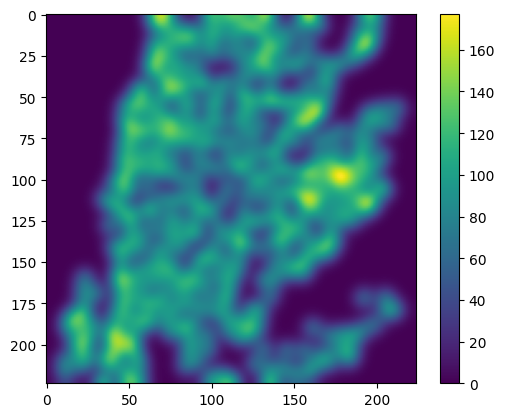

In [14]:
# Load points from JSON file
with open("./labels/090652_2.json", 'r') as file:
    data = json.load(file)
    points = data["shapes"]

image_path = "./images/090652_2.png"
image = cv2.imread(image_path, 0)  # Load the image as grayscale

img_shape=[image.shape[0], image.shape[1]]

density_map = np.zeros(img_shape, dtype=np.float32)

# Generate density maps based on annotations
for point in points:
    x, y = point["points"][0]
    x, y = int(x), int(y)
    density_map[y, x] += 1

density_map = gaussian_filter(density_map, sigma=5)*(25*255)  # Adjust sigma as needed

# Calculate overall count
overall_count = np.sum(density_map)/(255*25)

# Display the density map (optional)
cmap = 'viridis'
plt.imshow(density_map, cmap=cmap)
plt.colorbar()
plt.show

print(f"Overall Count: {overall_count}")
print("Channels:", len(density_map.shape))

### Creating the maps

In [27]:
# Path to your input folder containing JSON files and images
input_folder = "./labels"

# Gaussian kernel parameters
sigma = 5

# Path to the output folder for density maps
output_folder = f"./density_maps/"
os.makedirs(output_folder, exist_ok=True)

# Iterate over JSON files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".json"):
        json_path = os.path.join(input_folder, filename)

        # Load JSON data
        with open(json_path, "r") as json_file:
            data = json.load(json_file)
            points = data["shapes"]
        
        img_shape=[224, 224]

        # Create an empty density map with the same size as the image
        print("Shape of current image:",img_shape,". Totally generated",len(points),"gaussian kernels.")
        density_map = np.zeros(img_shape, dtype=np.float32)

        # Generate density maps based on annotations
        for point in points:
            x, y = point["points"][0]
            x, y = int(x), int(y)
            density_map[y, x] += 1

        density_map = gaussian_filter(density_map, sigma=sigma)*(255*sigma*5)  # Adjust sigma as needed

        # Debugging: Display the density map
        """ fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(density_map, cmap="viridis")
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(image) """

        # Save density map as an image
        output_filename = filename.replace(".json", ".png")
        output_path = os.path.join(output_folder, output_filename)
        cv2.imwrite(output_path, density_map)
        #break

print("Density maps generated and saved to the output folder.")

Shape of current image: [224, 224] . Totally generated 282 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 438 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 438 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 438 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 438 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 438 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 438 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 438 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 438 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 282 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 282 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 282 gaussian kernels.
Shape of current image: [224, 224] . Totally generated 282 gaussian kernels.

### Verifying the real number

Total number of grains: 438.2861714836857
Channels: 2


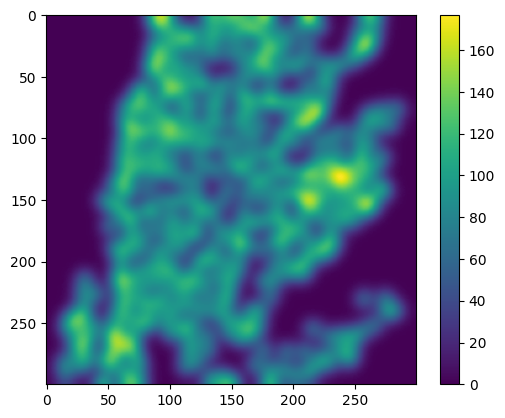

In [12]:
# Load the density map
density_map_path = "./density_maps/090652_2_aug_1.png"
density_map = cv2.imread(density_map_path, 0)  # Load the density map as grayscale
density_map = cv2.resize(density_map, (300, 300))

#total_density = np.sum(density_map)/(255*25) # For 224x224
total_density = np.sum(density_map)/(255*25*1.789) # For 300x300

cmap = 'viridis'
plt.imshow(density_map, cmap=cmap)
plt.colorbar()
plt.show

print("Total number of grains:", total_density)
print("Channels:", len(density_map.shape))

## Data augmentation pt.2

### Libraries

In [29]:
import os
import cv2

### Augmenting

In [35]:
def augment_images(input_folder, output_folder):

    # Loop through each image in the input folder
    for img_name in os.listdir(input_folder):
        # Check if the file is an image (you may want to add more checks based on your file types)
        if img_name.endswith(('.png')):
            img_path = os.path.join(input_folder, img_name)

            # Read the image
            img = cv2.imread(img_path)

            # Perform horizontal flip
            img_horizontal = cv2.flip(img, 1)
            save_path_horizontal = os.path.join(output_folder, f'{os.path.splitext(img_name)[0]}_horizontal.png')
            cv2.imwrite(save_path_horizontal, img_horizontal)

            # Perform vertical flip
            img_vertical = cv2.flip(img, 0)
            save_path_vertical = os.path.join(output_folder, f'{os.path.splitext(img_name)[0]}_vertical.png')
            cv2.imwrite(save_path_vertical, img_vertical)

            img_rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            save_path_rotated = os.path.join(output_folder, f'{os.path.splitext(img_name)[0]}_rotated_90.png')
            cv2.imwrite(save_path_rotated, img_rotated)

            img_rotated = cv2.rotate(img, cv2.ROTATE_180)
            save_path_rotated = os.path.join(output_folder, f'{os.path.splitext(img_name)[0]}_rotated_180.png')
            cv2.imwrite(save_path_rotated, img_rotated)

# Replace 'input_folder' and 'output_folder' with your actual input and output folder paths
augment_images('./density_maps/', './density_maps/')
augment_images('./images/', './images/')
print("Augmentation part.2 done")

Augmentation part.2 done


## Models

### Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D, BatchNormalization, Activation, Concatenate, ZeroPadding2D, AveragePooling2D
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Architecturing model

#### TCNN-Seed

In [3]:
def TCNN_seed(input_shape):
    # Create an input tensor
    input_tensor = Input(shape=input_shape)

    # Up
    x = Conv2D(40, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(80, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(40, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(20, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Down
    y = Conv2D(20, (5, 5), padding='same')(input_tensor)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling2D((2, 2), strides=(2, 2))(y)

    y = Conv2D(40, (5, 5), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling2D((2, 2), strides=(2, 2))(y)

    y = Conv2D(20, (5, 5), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv2D(10, (5, 5), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Concatenate the feature maps
    output = Concatenate()([x, y])

    # Upsample feature maps
    output = UpSampling2D(size=(4, 4))(output)
    output = Conv2D(2, (1, 1), padding='same')(output)

    # Create the model
    model = Model(inputs=input_tensor, outputs = output)

    return model

input_shape = (224, 224, 3)

model = TCNN_seed(input_shape)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 40  1120        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 224, 224, 20  1520        ['input_1[0][0]']                
                                )                                                             

#### MCNN

In [4]:
def MCNN(input_shape):
    # Create an input tensor
    input_tensor = Input(shape=input_shape)

    # Up
    x = Conv2D(16, (9, 9), padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(32, (7, 7), padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(16, (7, 7), padding='same', activation='relu')(x)
    
    x = Conv2D(8, (7, 7), padding='same', activation='relu')(x)

    # Down
    y = Conv2D(20, (7, 7), padding='same', activation='relu')(input_tensor)
    y = MaxPooling2D((2, 2), strides=(2, 2))(y)

    y = Conv2D(40, (5, 5), padding='same', activation='relu')(input_tensor)
    y = MaxPooling2D((2, 2), strides=(2, 2))(y)

    y = Conv2D(20, (5, 5), padding='same', activation='relu')(y)
    
    y = Conv2D(10, (5, 5), padding='same', activation='relu')(y)

    # Middle
    z = Conv2D(24, (5, 5), padding='same', activation='relu')(input_tensor)
    z = MaxPooling2D((2, 2), strides=(2, 2))(z)

    z = Conv2D(48, (3, 3), padding='same', activation='relu')(input_tensor)
    z = MaxPooling2D((2, 2), strides=(2, 2))(z)

    z = Conv2D(24, (3, 3), padding='same', activation='relu')(z)
    
    z = Conv2D(12, (3, 3), padding='same', activation='relu')(z)

    # Concatenate the feature maps
    output = Concatenate()([x, y, z])

    # Upsample feature maps
    output = UpSampling2D(size=(2, 2))(output)
    output = Conv2D(2, (1, 1), padding='same')(output)

    # Create the model
    model = Model(inputs=input_tensor, outputs = output)

    return model

input_shape = (224, 224, 3)

model = MCNN(input_shape)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 224, 224, 32  4736        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 224, 224, 40  3040        ['input_2[0][0]']                
                                )                                                           

#### CrowdNet

In [7]:
def crowdNet(input_shape):
    input_tensor = Input(shape=input_shape)

    # Deep Network
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_tensor)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(1, 1))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', dilation_rate=2)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Shallow Network
    y = Conv2D(24, (5, 5), padding='same', activation='relu')(input_tensor)
    y = AveragePooling2D((5, 5))(y)

    y = Conv2D(24, (5, 5), padding='same', activation='relu')(y)
    y = AveragePooling2D((5, 5), strides=(2, 2))(y)

    y = Conv2D(24, (5, 5), padding='same', activation='relu')(y)
    y = AveragePooling2D((5, 5), strides=(2, 2))(y)

    # Zero-padding to ensure consistent dimensions
    y = Conv2D(512, (5, 5), activation='relu', padding='same')(y)
    y = ZeroPadding2D(padding=(9, 9))(y)

    # Concatenate feature maps
    concatenated_features = Concatenate()([x, y])

    # Last conv
    z = Conv2D(1, (1, 1), activation='relu', padding='same')(concatenated_features)
   
    # Interpolating
    upsampled_features = UpSampling2D(size=(8, 8), interpolation='bilinear')(z)
    upsampled_features = ZeroPadding2D(padding=(8, 8))(upsampled_features)

    # Final convolutional layer for density map estimation
    density_map = Conv2D(2, (1, 1), activation='linear', padding='same')(upsampled_features)

    # Create the model
    model = Model(inputs=input_tensor, outputs=density_map)

    return model

# Input shape
input_shape = (224, 224, 3)

# Create an instance of the custom model
model = crowdNet(input_shape)

# Print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_18[0][0]']              
                                )                                                           

#### SorghumNet

In [5]:
def Sorghum_Net(input_shape):
    
    input_tensor = Input(shape=input_shape)
    
    # Up
    x = Conv2D(80, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(160, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(80, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(40, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Middle
    y = Conv2D(40, (5, 5), padding='same')(input_tensor)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling2D((2, 2), strides=(2, 2))(y)

    y = Conv2D(80, (5, 5), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling2D((2, 2), strides=(2, 2))(y)

    y = Conv2D(40, (5, 5), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    
    y = Conv2D(20, (5, 5), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Down
    z = Conv2D(20, (7, 7), padding='same')(input_tensor)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = MaxPooling2D((2, 2), strides=(2, 2))(z)

    z = Conv2D(40, (7, 7), padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = MaxPooling2D((2, 2), strides=(2, 2))(z)

    z = Conv2D(20, (7, 7), padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    
    z = Conv2D(40, (7, 7), padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)

    # Concatenate the feature maps
    concatenated = Concatenate()([x, y, z])

    # Upsample feature maps
    upsampled = UpSampling2D(size=(4, 4))(concatenated)
    output = Conv2D(2, (1, 1), padding='same')(upsampled)
    
    # Create the model
    model = Model(inputs=input_tensor, outputs=output)
    
    return model

input_shape = (224, 224, 3)

model = Sorghum_Net(input_shape)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 224, 224, 80  2240        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 224, 224, 40  3040        ['input_3[0][0]']                
                                )                                                           

### Split data into train and test

In [5]:
# Path to your X and Y directories
x_folder = "./images"
y_folder = "./density_maps"

# Get a list of file names from both X and Y directories
x_files = [os.path.splitext(file)[0] for file in os.listdir(x_folder) if file.endswith(".png")]
y_files = [os.path.splitext(file)[0] for file in os.listdir(y_folder) if file.endswith(".png")]

# Find matching pairs based on basenames
matched_files = list(set(x_files).intersection(y_files))

# Split the matched pairs into train and test sets
train_files, test_files = train_test_split(matched_files, test_size=0.2, random_state=123)

train_X = []
train_Y = []
test_X = []
test_Y = []

image_width, image_height = 224, 224

# Load and preprocess images
for file_basename in train_files:
    x_image_path = os.path.join(x_folder, file_basename + ".png")
    y_image_path = os.path.join(y_folder, file_basename + ".png")

    # Load images and resize them to the expected dimensions
    x_image = load_img(x_image_path, target_size=(image_width, image_height))
    y_image = load_img(y_image_path, target_size=(image_width, image_height), color_mode="grayscale")

    # Convert images to NumPy arrays
    x_image_array = img_to_array(x_image)
    y_image_array = img_to_array(y_image)

    train_X.append(x_image_array)
    train_Y.append(y_image_array)

# Similarly, load and preprocess images for the test set
for file_basename in test_files:
    x_image_path = os.path.join(x_folder, file_basename + ".png")
    y_image_path = os.path.join(y_folder, file_basename + ".png")

    x_image = load_img(x_image_path, target_size=(image_width, image_height))
    y_image = load_img(y_image_path, target_size=(image_width, image_height), color_mode="grayscale")

    x_image_array = img_to_array(x_image)
    y_image_array = img_to_array(y_image)

    test_X.append(x_image_array)
    test_Y.append(y_image_array)

# Convert the lists of images to NumPy arrays
train_X = np.array(train_X, dtype=np.float32)
train_Y = np.array(train_Y, dtype=np.float32)
test_X = np.array(test_X, dtype=np.float32)
test_Y = np.array(test_Y, dtype=np.float32)

print("Size of train:", len(train_X))
print("Size of test:", len(test_X))

Size of train: 3840
Size of test: 960


### Compile and train the model

In [6]:
# Define the paths for the checkpoints and logs
checkpoint_path = "./weights/Sorghum_Net_weights.h5"

if os.path.exists(checkpoint_path):
    # Load the model from the saved checkpoint
    model = load_model(checkpoint_path)

# Create a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor='val_loss',
    mode='auto',
    verbose=1,
    save_weights_only=False,
    restore_best_weights=True
)

# Create an EarlyStopping callback with patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='auto',
    verbose=1,
    restore_best_weights=True
)

# Compile the model with the Gaussian Kernel Loss
model.compile(optimizer='Adam', loss=tf.keras.losses.MeanSquaredError(), metrics=["accuracy"])

# Train the model
model.fit(train_X,
          train_Y,
          epochs = 200,
          batch_size = 8,
          validation_data=(test_X, test_Y),
          callbacks=[model_checkpoint, early_stopping])

Epoch 1/200
480/480 [==============================] - ETA: 0s - loss: 1554.8531 - accuracy: 0.2759
Epoch 1: val_loss improved from inf to 896.31439, saving model to ./weights\Sorghum_Net_weights.h5
480/480 [==============================] - 44s 75ms/step - loss: 1554.8531 - accuracy: 0.2759 - val_loss: 896.3144 - val_accuracy: 0.1289
Epoch 2/200
480/480 [==============================] - ETA: 0s - loss: 848.1058 - accuracy: 0.2689
Epoch 2: val_loss did not improve from 896.31439
480/480 [==============================] - 35s 72ms/step - loss: 848.1058 - accuracy: 0.2689 - val_loss: 956.2585 - val_accuracy: 0.3426
Epoch 3/200
480/480 [==============================] - ETA: 0s - loss: 799.0432 - accuracy: 0.1854
Epoch 3: val_loss improved from 896.31439 to 790.17029, saving model to ./weights\Sorghum_Net_weights.h5
480/480 [==============================] - 35s 73ms/step - loss: 799.0432 - accuracy: 0.1854 - val_loss: 790.1703 - val_accuracy: 0.3165
Epoch 4/200
480/480 [================

### Making inferences

In [26]:
input_shape = (224, 224, 3)

#inference_model = TCNN_seed(input_shape)
inference_model = MCNN(input_shape)
#inference_model = crowdNet(input_shape)
#inference_model = Sorghum_Net(input_shape)

#inference_model.load_weights('./weights/TCNN_seed_weights.h5')
inference_model.load_weights('./weights/MCNN_weights.h5')
#inference_model.load_weights('./weights/Crowd_Net_weights.h5')
#inference_model.load_weights('./weights/Sorghum_Net_weights.h5')

1/1 [==============================] - 0s 84ms/step


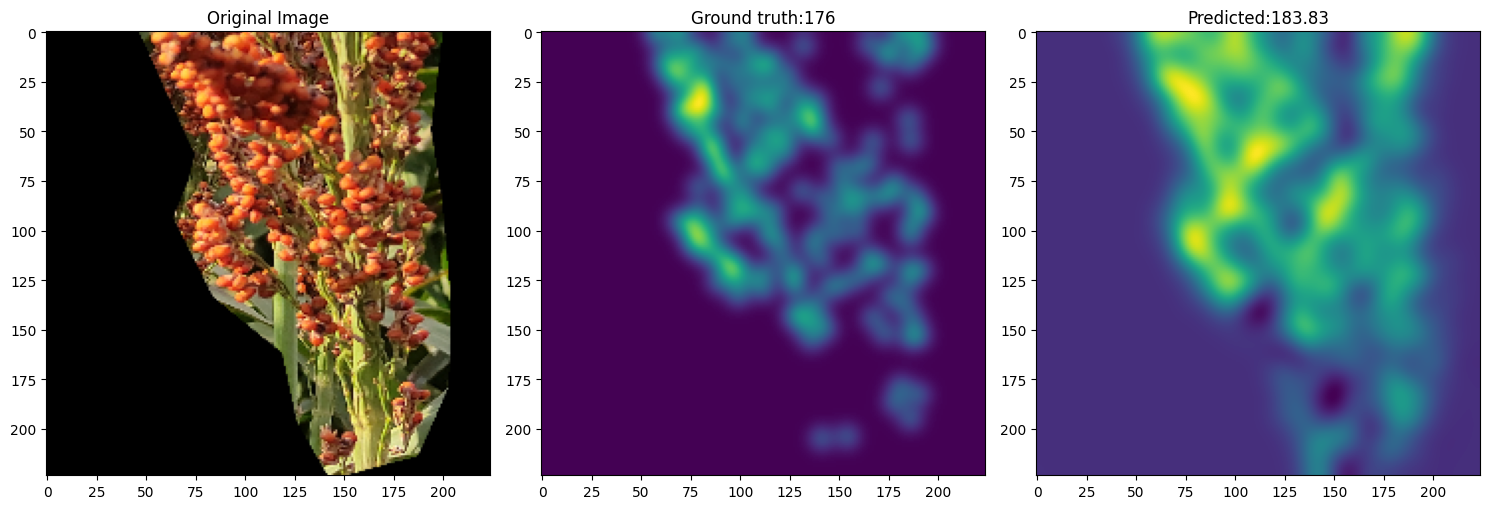

In [27]:
# Image
new_image_path = "./test_images/2_093707.png"
image = cv2.imread(new_image_path, 0)
image = cv2.resize(image, [224,224])

image_to_show = cv2.imread(new_image_path)
image_to_show = cv2.resize(image_to_show, [224,224])
image_to_show = cv2.cvtColor(image_to_show,cv2.COLOR_BGR2RGB)

# GT density map
density_map = os.path.splitext(new_image_path)[0] + f"_density.png"
density_map_to_show = cv2.imread(density_map, 0)
density_map_to_show = cv2.resize(density_map_to_show, [224,224])

overall_count = np.sum(density_map_to_show)/(255*25)

image_width, image_height = 224, 224

new_image = load_img(new_image_path, target_size=(image_width, image_height))
new_image_array = img_to_array(new_image)

new_image_array = np.array(new_image_array, dtype=np.float32)

predictions = inference_model.predict(np.expand_dims(new_image_array, axis=0))

probability_map = predictions[0, :, :, 0]
prediction = np.sum(probability_map)/(255*25)

smoothed_map = gaussian_filter(probability_map, sigma=5)

# Create a figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image with title
axes[0].imshow(image_to_show)
axes[0].set_title('Original Image')

# Display the ground truth image with title
axes[1].imshow(density_map_to_show, cmap='viridis')
axes[1].set_title('Ground truth:{0}'.format(round(overall_count)))

# Display the predicted image with title
axes[2].imshow(smoothed_map, cmap='viridis')
axes[2].set_title('Predicted:{0}'.format(round(prediction,2)))

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Evaluating the model

In [11]:
gt_array = []
pred_array = []

# Similarly, load and preprocess images for the test set
for file_basename in test_files:

    y_image_path = os.path.join(y_folder, file_basename + ".png")
    density_map = cv2.imread(y_image_path, 0)
    ground_truth = np.sum(density_map)/(255*25)
    gt_array.append(ground_truth)

    x_image_path = os.path.join(x_folder, file_basename + ".png")
    image_width, image_height = 224, 224
    new_image = load_img(x_image_path, target_size=(image_width, image_height))
    new_image_array = img_to_array(new_image)
    new_image_array = np.array(new_image_array, dtype=np.float32)
    predictions = inference_model.predict(np.expand_dims(new_image_array, axis=0))
    probability_map = predictions[0, :, :, 0]
    predicted = np.sum(probability_map)/(255*25)
    pred_array.append(predicted)

# Calculate the average metrics across all test samples
average_mae = mean_absolute_error(gt_array, pred_array)
average_mse = mean_squared_error(gt_array, pred_array)
average_mape = mean_absolute_percentage_error(gt_array, pred_array)*100

# Print the metrics
print("Mean Absolute Error (MAE):", average_mae)
print("Mean Squared Error (MSE):", average_mse)
print("Mean Absolute Percentage Error (MAPE):", average_mape, "%")

1/1 [==============================] - 0s 17ms/step
Mean Absolute Error (MAE): 25.8660477124183
Mean Squared Error (MSE): 1271.4155027155987
Mean Absolute Percentage Error (MAPE): 16.827647037042954 %
